# Numpy 배열 연산: 유니버설 함수
1. 루프는 느리다
2. UFuncs 소개
3. Numpy 유니버설 함수(UFuncs)
4. 고급 UFunc 기능
5. 집계: 최솟갑, 최대값, 그리고 그 사이의 모든 것
6. 예제: 미국 대통령의 평균 신장은 얼마일까?

- Numpy는 데이터 배열을 사용하여 최적화된 연산을 위한 쉽고 유연한 인터페이스 제공
- Numpy 배열 연산을 빠르게 만드는 핵심은 벡터화 -> universal function 통해 구현

### 1. 루프는 느리다: universal function의 필요성
- 파이썬 기본 구현(CPython)에서 몇 가지 연산은 매우 느리게 수행
- 부분적으로는 파이썬이 동적인 인터프리터 언어이기 때문
- 타입이 유연하다 = 연산이 C나 Fortran에서처럼 효율적인 머신 코드로 컴파일 되기 어려움
- 파이썬은 작은 연산이 반복되는 상황에서 확연히 느리다

Syntax
- numpy.random.randint(low, high=None, size=None, dtype=int)

[Summary]
- low: The lower bound (inclusive) of the random integers.
- high: The upper bound (exclusive) of the random integers. If not provided, the range is [0, low).
- size: The shape of the output array. If not provided, a single integer is returned.
- dtype: The data type of the output array. Default is int.

In [2]:
import numpy as np

# generate a single random number btw 0(inclusive) and 10(exclusive)
random_int = np.random.randint(10)
print(random_int)

#generate a single random integer bewtween 5(inclusive) and 10 (exclusive)
random_int2 = np.random.randint(5,10)
print(random_int2)

# generate a 1D array containing 5 random integers btw 0(inclusive) and 10(exclusive)
random_array = np.random.randint(0,10,size=5)
print(random_array)

# generate a 2D array containing 3 rows and 3 columns of random integers btw 0(inclusive) and 10(exclusive)
random_array2 = np.random.randint(0,10,(3,3))
print(random_array2)

# speficy data type
# generate a 1D array containing 5 random integers between 0(inclusive) and 10(exclusive) with data type int64
random_array_dtype = np.random.randint(0,10,size=5, dtype='int64')
print(random_array_dtype)

1
7
[5 3 3 2 8]
[[4 2 2]
 [9 7 8]
 [3 8 5]]
[3 4 6 5 9]


In [3]:
# example. 값으로 이뤄진 배열이 있고 각각의 역수를 계산하려고 한다.

np.random.seed(0)
def compute_reciprocals(values):
    output = np.empty(len(values))
    for i in range(len(values)):
        output[i] = 1.0 / values[i]
    return output


values = np.random.randint(1, 10, size=5)
compute_reciprocals(values)

array([0.16666667, 1.        , 0.25      , 0.25      , 0.125     ])

In [4]:
# 이 코드는 큰 배열을 다룰 때 매우 느리다. 이유는 반복문을 사용하고 있기 때문이다.
# %timeit을 사용해 속도 측정

big_array = np.random.randint(1, 100, size = 1000000)
%timeit compute_reciprocals(big_array)

2.49 s ± 88.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 병목은 연산 자체에 있는 것이 아니라 CPython이 루프의 사이클마다 수행해야 하는 타입 확인과 함수 디스패치에서 발생함
- CPython 사이클: 객체 타입 확인 > 해당 타입에 맞게 사용할 함수 동적 검색 > 이후 연산
- 컴파일된 코드로 작업했다면 코드 실행 전 타입을 알았을 것. 결괏값 계산 효율적이었을 것.

### 2. UFuncs 소개
NumPy는 여러 종류의 연산에 대해 정적 타입 체계를 가진 컴파일된 루틴에 편리한 인터페이스 제공
- 벡터화 연산: 배열에 연산을 수행해 각 요소에 적용함. 루프를 NumPy의 기저를 이루는 컴파일된 계층으로 밀어넣음으로써 훨씬 빠르게 실행되도록 설계됨 

In [5]:
print(compute_reciprocals(values))
print(1.0/values)

[0.16666667 1.         0.25       0.25       0.125     ]
[0.16666667 1.         0.25       0.25       0.125     ]


In [6]:
# 파이썬 루프보다 이 실행코드가 수백 배 빠른 속도로 작업을 완료함
%timeit (1.0/big_array)

4.33 ms ± 609 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- NumPy에서 벡터화 연산은 NumPy 배열의 값에 반복된 연산을 빠르게 수행하는 것을 주목적으로 하는 ufuncs를 통해 구현됨
- 유니버설 함수는 매우 유연: 스칼라<>배열, 배열<>배열, 다차원 배열..

In [7]:
# 스칼라<>배열
1.0/big_array

array([0.1       , 0.01190476, 0.04545455, ..., 0.01428571, 0.01098901,
       0.01149425])

In [8]:
# 배열<>배열
np.arange(5)/np.arange(1,6)


array([0.        , 0.5       , 0.66666667, 0.75      , 0.8       ])

1. True Division (/):
Always returns a floating-point result.
Preserves the fractional part of the division.

2. Floor Division (//):
Returns the largest integer less than or equal to the division result.
Discards the fractional part of the division.

In [9]:
# 다차원 배열
x = np.arange(9).reshape((3,3))
x**2

array([[ 0,  1,  4],
       [ 9, 16, 25],
       [36, 49, 64]])

### 3. NumPy 유니버설 함수 (UFuncs)
- 단항 ufunc:  단일 입력값에 동작
- 이항 ufuncs:  두 개의 입력값에 동작

In [10]:
#배열 산술 연산
# NumPy는 기본 산술 연산자를 사용해 배열에 대한 요소별 연산을 수행한다.
x = np.arange(4)
print("x     =", x)
print("x + 5 =", x + 5)
print("x - 5 =", x - 5)
print("x * 2 =", x * 2)
print("x / 2 =", x / 2)
print("x // 2 =", x // 2)  # 나눗셈의 몫

x     = [0 1 2 3]
x + 5 = [5 6 7 8]
x - 5 = [-5 -4 -3 -2]
x * 2 = [0 2 4 6]
x / 2 = [0.  0.5 1.  1.5]
x // 2 = [0 0 1 1]


In [11]:
# 음수를 만드는 단항 연산자 "-"
# 지수 연산자 "**"
# 나머지 연산자 "%"
print("-x    =", -x)
print("x**2  =", x**2)
print("x % 2 =", x % 2)

-x    = [ 0 -1 -2 -3]
x**2  = [0 1 4 9]
x % 2 = [0 1 0 1]


In [12]:
# 이 연산들은 원하는 만큼 함께 사용할 수 있고 표준 연산 순서를 따른다.
-(0.5*x+1)**2

array([-1.  , -2.25, -4.  , -6.25])

In [13]:
# 이 산술연산은 모두 사용상 편의를 위해 NumPy에 내장된 특정 항수를 감싼 것이다.
# 예를 들어 + 연산자는 add 함수의 래퍼(wrapper)이다.
np.add(x,2)

array([2, 3, 4, 5])

In [14]:
# 절대값 함수
x = np.array([-2, -1, 0, 1, 2])
abs(x)

array([2, 1, 0, 1, 2])

In [15]:
np.absolute(x)

array([2, 1, 0, 1, 2])

In [16]:
np.abs(x)

array([2, 1, 0, 1, 2])

In [17]:
# 이 함수는 복소수 데이터에도 동작한다.
# 복소수의 크기는 제곱합의 제곱근이다.
x=np.array([3-4j, 4-3j, 2+0j, 0+1j])
np.abs(x)

array([5., 5., 2., 1.])

- Python에서 허수는 j이다.
- 복소수는 a + bj의 형태로 표현한다
- In Python, the letter j is used to denote the imaginary part of a complex number. Complex numbers are numbers that have both a real part and an imaginary part. The imaginary unit j is equivalent to the square root of -1.

1. Creating a Complex Array:

```x = np.array([3-4j, 4-3j, 2+0j, 0+1j])```

- This creates a NumPy array x containing complex numbers.
> 3-4j represents the complex number with a real part of 3 and an imaginary part of -4.  
> 4-3j represents the complex number with a real part of 4 and an imaginary part  of -3.  
> 2+0j represents the complex number with a real part of 2 and an imaginary part of 0.  
> 0+1j represents the complex number with a real part of 0 and an imaginary part of 1.  

2. Calculating the Magnitude (Absolute Value):

```np.abs(x)```

- The np.abs function computes the magnitude (or absolute value) of each complex number in the array.
- The magnitude of a complex number a + bj is calculated as sqrt(a^2 + b^2).

> Example Calculation  
> For 3-4j:  
>
> Real part: 3  
> Imaginary part: -4  
> Magnitude: sqrt(3^2 + (-4)^2) = sqrt(9 + 16) = sqrt(25) = 5  
> For 4-3j:  
>
>Real part: 4  
>Imaginary part: -3  
>Magnitude: sqrt(4^2 + (-3)^2) = sqrt(16 + 9) = sqrt(25) = 5  
>For 2+0j:  
>
>Real part: 2  
>Imaginary part: 0  
>Magnitude: sqrt(2^2 + 0^2) = sqrt(4) = 2  
>For 0+1j:  
>
>Real part: 0  
>Imaginary part: 1  
>Magnitude: sqrt(0^2 + 1^2) = sqrt(1) = 1  
>Output  
>The output of np.abs(x) will be:  
```array([5., 5., 2., 1.])```

3. Summary
j: Denotes the imaginary part of a complex number in Python.
np.abs: Computes the magnitude of each complex number in the array.
Magnitude Calculation: For a complex number a + bj, the magnitude is sqrt(a^2 + b^2).

4. More Info
- 복소수와 허수
- https://ko.khanacademy.org/math/algebra2/x2ec2f6f830c9fb89:complex/x2ec2f6f830c9fb89:complex-num/a/intro-to-complex-numbers
- https://namu.wiki/w/%ED%97%88%EC%88%98

- 행렬과 행렬의 연산
- https://sasamath.com/blog/invitation-to-calculus/complex-numbers/
- https://recipesds.tistory.com/entry/%EC%84%A0%ED%98%95%EB%8C%80%EC%88%98%EB%9D%BC%EA%B3%A0-%ED%95%98%EA%B8%B0%EC%97%94-%EB%84%88%EB%AC%B4-%EA%B1%B0%EC%B0%BD%ED%95%98%EA%B3%A0-%EA%B0%84%EB%8B%A8%ED%95%9C-%ED%96%89%EB%A0%AC%EA%B3%B1-%EC%A0%95%EB%8F%84%EC%9D%98-%EC%9D%B4%ED%95%B4
- https://jinconomics.tistory.com/6

##### 삼각함수

In [18]:
# Generate theta Values
theta = np.linspace(0, np.pi, 3)

# np.linspace(start, stop, num) generates num evenly spaced values between
# start and stop (inclusive).
# Here, np.linspace(0, np.pi, 3) generates 3 values between 0 and π (inclusive).

In [19]:
print("theta     =", theta)
print("sin(theta)=", np.sin(theta)) # computes the sine of each value in the theta array.
print("cos(theta)=", np.cos(theta)) # computes the cosine of each value in the theta array.
print("tan(theta)=", np.tan(theta)) # computes the tangent of each value in the theta array.

theta     = [0.         1.57079633 3.14159265]
sin(theta)= [0.0000000e+00 1.0000000e+00 1.2246468e-16]
cos(theta)= [ 1.000000e+00  6.123234e-17 -1.000000e+00]
tan(theta)= [ 0.00000000e+00  1.63312394e+16 -1.22464680e-16]


#### Trigonometric Functions
Trigonometric functions relate the angles of a triangle to the lengths of its sides. They are primarily used in the context of right-angled triangles and are also fundamental in describing periodic phenomena. The main trigonometric functions are:

>Sine (sin):  
>Definition: In a right-angled triangle, it is the ratio of the length of the opposite side to the hypotenuse.  
>Formula: sin(θ) = opposite / hypotenuse  

>Cosine (cos):  
>Definition: In a right-angled triangle, it is the ratio of the length of the adjacent side to the hypotenuse.  
>Formula: cos(θ) = adjacent / hypotenuse  

>Tangent (tan):  
>Definition: In a right-angled triangle, it is the ratio of the length of the opposite side to the adjacent side.  
>Formula: tan(θ) = opposite / adjacent

In [20]:
# 역삼각함수
x = [-1, 0, 1]
print("x     =", x)
print("arcsin(x)=", np.arcsin(x)) # computes the arcsine of each value in the x array.
print("arccos(x)=", np.arccos(x)) # computes the arccosine of each value in the x array.
print("arctan(x)=", np.arctan(x)) # computes the arctangent of each value in the x array.

x     = [-1, 0, 1]
arcsin(x)= [-1.57079633  0.          1.57079633]
arccos(x)= [3.14159265 1.57079633 0.        ]
arctan(x)= [-0.78539816  0.          0.78539816]


#### Inverse Trigonometric Functions
Inverse trigonometric functions are the inverses of the trigonometric functions. They return the angle corresponding to a given trigonometric value. The main inverse trigonometric functions are:  

>Arcsine (asin or arcsin):  
> Definition: Returns the angle whose sine is a given number.  
> Formula: θ = arcsin(x) means sin(θ) = x  

> Arccosine (acos or arccos):  
> Definition: Returns the angle whose cosine is a given number.  
> Formula: θ = arccos(x) means cos(θ) = x  

> Arctangent (atan or arctan):  
>Definition: Returns the angle whose tangent is a given number.  
>Formula: θ = arctan(x) means tan(θ) = x

##### 지수와 로그

In [21]:
x = [1,2,3]
print("X    =", x)
print("e^x  =", np.exp(x)) # computes the exponential of each value in the X array.
print("2^x =", np.exp2(x))  # computes 2 raised to the power of each value in the x array.
print("3^x =", np.power(3,x)) # computes 3 raised to the power of each value in the x array.

X    = [1, 2, 3]
e^x  = [ 2.71828183  7.3890561  20.08553692]
2^x = [2. 4. 8.]
3^x = [ 3  9 27]


##### Exponential Function
The exponential function is a mathematical function denoted by exp(x) or e^x, where e is Euler's number (approximately 2.71828). It is a fundamental function in mathematics with the following properties:  

>Growth Rate: The exponential function grows rapidly as x increases.  
>Derivative: The derivative of e^x with respect to x is e^x, making it unique among functions.  
>Inverse: The natural logarithm function ln(x) is the inverse of the exponential function.

> 참고:
> https://blog.naver.com/dhkdwnddml/221032980702

In [22]:
np.exp2?

Signature:       np.exp2(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'exp2'>
File:            c:\users\chels\anaconda3\envs\emerald_city\lib\site-packages\numpy\__init__.py
Docstring:      
exp2(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature])

Calculate `2**p` for all `p` in the input array.

Parameters
----------
x : array_like
    Input values.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condition is True, the `out` array will be set to the ufunc result.
    Elsewhere, the `out` array will retain its original value.
 

In [23]:
x = [1,2,4,10]
print("x     =", x)
print("ln(x)  =", np.log(x)) # computes the natural logarithm of each value in the x array.
print("log2(x)=", np.log2(x)) # computes the base-2 logarithm of each value in the x array.
print("log10(x)=", np.log10(x)) # computes the base-10 logarithm of each value in the x array.

x     = [1, 2, 4, 10]
ln(x)  = [0.         0.69314718 1.38629436 2.30258509]
log2(x)= [0.         1.         2.         3.32192809]
log10(x)= [0.         0.30103    0.60205999 1.        ]


#### 특화된 유니버설 함수

In [24]:
from scipy import special
# Gamma functions (generalized factorials) and related functions
x = [1, 5, 10]
print("gamma(x)     =", special.gamma(x)) # computes the gamma function of each value in the x array.
print("ln|gamma(x)| =", special.gammaln(x)) # computes the natural logarithm of the absolute value of the gamma function of each value in the x array.
print("beta(x, 2)   =", special.beta(x, 2)) # computes the beta function of each value in the x array with 2.

gamma(x)     = [1.0000e+00 2.4000e+01 3.6288e+05]
ln|gamma(x)| = [ 0.          3.17805383 12.80182748]
beta(x, 2)   = [0.5        0.03333333 0.00909091]


In [25]:
# Error function (integral of Gaussian)
# its complement, and its inverse
x = np.array([0, 0.3, 0.7, 1.0])
print("erf(x)  =", special.erf(x)) # computes the error function of each value in the x array.
print("erfc(x) =", special.erfc(x)) # computes the complementary error function of each value in the x array.
print("erfinv(x)=", special.erfinv(x)) # computes the inverse of the error function for each value in the x array.

erf(x)  = [0.         0.32862676 0.67780119 0.84270079]
erfc(x) = [1.         0.67137324 0.32219881 0.15729921]
erfinv(x)= [0.         0.27246271 0.73286908        inf]


##### 고급 Ufunc 기능
- 출력 지정: 대단히 큰 규모의 배열에서는 out 인수를 신중하게 사용해 절약되는 메모리가 크다
- 집계
- 외적

In [26]:
# 출력지정
x = np.arange(5)
y = np.empty(5)
np.multiply(x, 10, out=y) # 모든 ufunc은 선택적으로 출력 지정을 할 수 있다.
print(y)

[ 0. 10. 20. 30. 40.]


In [27]:
y = np.zeros(10)
np.power(2,x, out=y[0:9:2]) # 배열 슬라이스를 사용해 연산 결과를 지정한 배열의 요소에 저장할 수 있다.
print(y)

[ 1.  0.  2.  0.  4.  0.  8.  0. 16.  0.]


In [28]:
# 집계
# 배열을 특정 연산으로 축소하는 것을 집계라고 한다.
x = np.arange(1,6)
np.add.reduce(x) # 모든 배열 요소의 합을 반환한다.

np.int64(15)

In [29]:
np.multiply.reduce(x) # 모든 배열 요소의 곱을 반환한다.

np.int64(120)

In [30]:
# 계산의 중간 결과를 저장하고 싶다면 accumulate를 사용한다.
np.add.accumulate(x)

array([ 1,  3,  6, 10, 15])

In [31]:
np.multiply.accumulate(x)

array([  1,   2,   6,  24, 120])

#### 외적 (Outer products)

In [32]:
x = np.arange(1,6)
np.multiply.outer(x,x) # outer method는 두 입력 배열의 외적을 계산한다.

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25]])

#### 5. 집계: 최솟갑, 최대값, 그리고 그 사이의 모든 것
- 배열의 값의 합 구하기
- 최솟갑소가 최댓값
- 다차원 집계
- 기타 집계 함수

In [33]:
# 배열의 값의 합 구하기 # 파이썬 내장 함수
L = np.random.random(100)
sum(L)

np.float64(50.461758453195614)

In [34]:
# 넘파이 함수
np.sum(L)

np.float64(50.46175845319564)

In [35]:
# 간단한 계산에서는 결과가 같지만 넘파이 함수가 컴파일된 코드에서 실행되서 더 빠름
big_array = np.random.rand(1000000)
%timeit sum(big_array)
%timeit np.sum(big_array)

101 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.37 ms ± 95.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


##### 최솟값과 최댓값

In [36]:
# 파이썬 내장함수 min, max
min(big_array), max(big_array)

(np.float64(7.071203171893359e-07), np.float64(0.9999997207656334))

In [37]:
# np.min, np.max
np.min(big_array), np.max(big_array)

(np.float64(7.071203171893359e-07), np.float64(0.9999997207656334))

In [38]:
%timeit min(big_array)
%timeit np.min(big_array)

79 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
623 μs ± 122 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
# min, max, sum....비롯한 집계 함수는 배열 객체 자체의 메서드를 사용하는 더 짧은 구문 
# 이용 가능
# NumPy 배열 객체의 메서드를 사용하는 것이 더 짧고 가독성이 높다. (가능한 이렇게 사용)
print(big_array.min(), big_array.max(), big_array.sum())

7.071203171893359e-07 0.9999997207656334 500216.8034810001


##### 다차원 집계

In [40]:
M = np.random.random((3,4))
print(M)

[[0.79832448 0.44923861 0.95274259 0.03193135]
 [0.18441813 0.71417358 0.76371195 0.11957117]
 [0.37578601 0.11936151 0.37497044 0.22944653]]


In [41]:
M.sum()

np.float64(5.1136763453287335)

In [42]:
M.min(axis=0) # 각 열의 최솟값

array([0.18441813, 0.11936151, 0.37497044, 0.03193135])

In [43]:
M.max(axis=1) # 각 행의 최댓값

array([0.95274259, 0.76371195, 0.37578601])

In [44]:
np.all(M <1)

np.True_

In [45]:
np.any (M > 1)

np.False_

In [46]:
np.percentile(big_array, q=50)

np.float64(0.500381226077177)

In [47]:
np.median(big_array)

np.float64(0.500381226077177)

In [48]:
np.argmax(big_array)

np.int64(154697)

In [49]:
np.argmin(big_array)

np.int64(14443)

In [50]:
np.var(big_array)

np.float64(0.08343373559084719)

In [51]:
np.std(big_array)

np.float64(0.2888489840571491)

In [52]:
np.mean(big_array)

np.float64(0.5002168034810002)

In [53]:
np.prod(big_array)

np.float64(0.0)

In [54]:
np.nanprod(big_array)

np.float64(0.0)

In [55]:
np.sum(big_array)

np.float64(500216.8034810001)

### 6. 예제: 미국 대통령의 평균 신장은 얼마일까?

In [56]:
!head -4 data/president_heights.csv

'head'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [57]:
import numpy as np
import pandas as pd
data = pd.read_csv('data/president_heights.csv')
heights = np.array(data['height(cm)'])
print(heights)

[189 170 189 163 183 171 185 168 173 183 173 173 175 178 183 193 178 173
 174 183 183 168 170 178 182 180 183 178 182 188 175 179 183 193 182 183
 177 185 188 188 182 185 191 182]


In [58]:
print("Mean height:      ", heights.mean())
print("Standard deviation:", heights.std())
print("Minimum height:   ", heights.min())
print("Maximum heights:   ", heights.max())

Mean height:       180.04545454545453
Standard deviation: 6.983599441335736
Minimum height:    163
Maximum heights:    193


In [59]:
print("25th percentile:   ", np.percentile(heights, 25))
print("Median:        ", np.median(heights))
print("75th percentile:    ", np.percentile(heights, 75))


25th percentile:    174.75
Median:         182.0
75th percentile:     183.5


Text(0, 0.5, 'number')

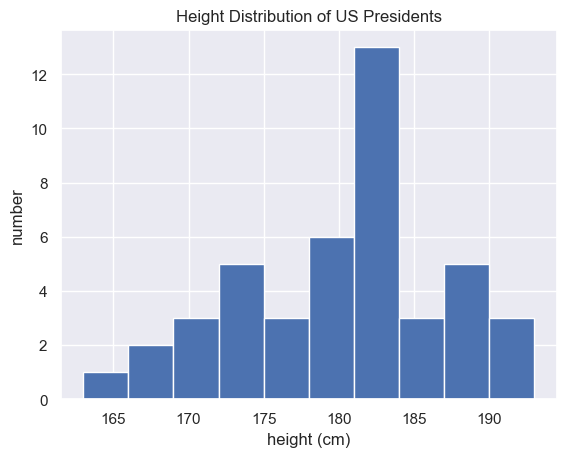

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

plt.hist(heights)
plt.title('Height Distribution of US Presidents')
plt.xlabel('height (cm)')
plt.ylabel('number')

##### seaborn 오류 해결: conda install seaborn -c conda-forge로 최신 버전 seaborn 설치 후 재부팅